# **Data Bootcamp Final Project**
## By Elizabeth Tang

---
### **Project Description**: Holiday-Driven Consumer Insight Analysis of Engagement on Social Media Across Brands

*   Does consumer sentiments increase or decrease around holidays for different brands?

*   How does social media engagement correlate with holiday-specific advertising expenditures?

*   Can we classify whether a day is “holiday period” vs “normal period” through sentiment and engagement analysis?

*   Is it possible to cluster brands into groups based on holiday sentiment patterns?

*   How to forecast brand perception around holidays using time-series models?

*   Can neural networks predict sentiment numeric WRDS metrics (ANN regression), classification of holiday vs nonholiday periods (ANN classification), and textual news headlines from RavenPack (ANN NLP model)?

### **Purpose**

This project analyzes how consumer sentiment, engagement, and behavior toward major brands shift around holidays and seasonal events (such as Black Friday, Christmas, Super Bowl, or Valentine's Day) by using a combination of social media data, advertising expenditure, and market performance from WRDS datasets (RavenPack) and Google Trends.

The final project integrates econometrics, supervised and unsupervised machine learning, time-series forecasting, and modern neural networks in order to visualize holiday-driven shifts in consumption, predicting consumer engagement, grouping brands by holiday season performance, and forecasts brand reputation over time, as well as analyzes news headlines/social buzz with NLP neural networks.

### **Contents**
1. Dataset: RavenPack
2. Dataset: Google Trends
3. Dataset: US Holiday Calendar
4. Dataset: Merged Data
5. Analysis Questions
6. Conclusion



---



In [ ]:
# # install WRDS (needed once)
# !pip install wrds

# # install pytrends for google trends
# !pip install pytrends
# !pip install wrds pytrends pandas numpy scikit-learn statsmodels tensorflow keras xgboost matplotlib seaborn plotly holidays prophet

# # install prophet (needed once) --> used for time series forecasting
# !pip install cmdstanpy prophet

# # install transformers
# !pip install transformers

# # install Streamlit
# !pip install streamlit

import streamlit as st
from transformers import pipeline

import os, sys, time
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

# modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
import wrds
database = wrds.Connection()

# see the libraries available to my WRDS account
database.list_libraries()

Enter your WRDS username [root]:eyt8724
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


['aha_sample',
 'ahasamp',
 'auditsmp',
 'auditsmp_all',
 'bank',
 'bank_all',
 'bank_premium_samp',
 'banksamp',
 'block',
 'block_all',
 'boardex_trial',
 'boardsmp',
 'bvd_amadeus_trial',
 'bvd_bvdbankf_trial',
 'bvd_orbis_trial',
 'bvdsamp',
 'calcbench_trial',
 'calcbnch',
 'candid_samp',
 'cboe',
 'cboe_all',
 'cboe_sample',
 'cboesamp',
 'cddsamp',
 'ciq',
 'ciq_capstrct',
 'ciq_common',
 'ciq_keydev',
 'ciq_pplintel',
 'ciqsamp',
 'ciqsamp_capstrct',
 'ciqsamp_common',
 'ciqsamp_keydev',
 'ciqsamp_pplintel',
 'ciqsamp_ratings',
 'ciqsamp_transactions',
 'ciqsamp_transcripts',
 'cisdmsmp',
 'columnar',
 'comp',
 'comp_bank_daily',
 'comp_execucomp',
 'comp_filings',
 'comp_global_daily',
 'comp_na_daily_all',
 'comp_segments_hist_daily',
 'compsamp',
 'compsamp_all',
 'compsamp_snapshot',
 'compseg',
 'contrib',
 'contrib_as_filed_financials',
 'contrib_ceo_turnover',
 'contrib_char_returns',
 'contrib_corporate_bond_returns',
 'contrib_corporate_culture',
 'contrib_general',
 '

In [3]:
from pytrends.request import TrendReq

# US location
pytrends = TrendReq(hl = 'en-US', tz = 360)

In [4]:
# clone data from github files from Elizabeth (LIZonga)
# !git clone -b final_data_files https://github.com/LIZonga/data_bootcamp_final.git

# **Dataset: RavenPack**

Includes information on news, social media, files, and insight like sentiment scores and impact. This data can help with optimization.







In [5]:
# SQL for managing and manipulating data in relational databases
sql = """
SELECT
    CAST(rpa_date_utc AS DATE) AS date,
    entity_name AS brand,
    AVG(event_sentiment_score) AS sentiment,
    SUM(rp_story_event_count) AS mentions,
    SUM(relevance) AS buzz
FROM ravenpack_trial.rpa_full_equities
WHERE rpa_date_utc BETWEEN '2020-01-01' AND '2025-01-01'
GROUP BY date, brand
ORDER BY date, brand
"""
# create the ravenpack DataFrame
ravenpack_df = database.raw_sql(sql)

In [6]:
ravenpack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16228 entries, 0 to 16227
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       16228 non-null  string 
 1   brand      16228 non-null  string 
 2   sentiment  6087 non-null   Float64
 3   mentions   16228 non-null  Float64
 4   buzz       16228 non-null  Float64
dtypes: Float64(3), string(2)
memory usage: 681.6 KB


In [7]:
# show the DataFrame
ravenpack_df.head()

,date,brand,sentiment,mentions,buzz
0,2020-09-30,100 Enterprises International Group Co. Ltd.,<NA>,260.0,1306.0
1,2020-09-30,10X Genomics Inc.,<NA>,562.0,950.0
2,2020-09-30,111 Inc.,0.49,225.0,1598.0
3,2020-09-30,11 88 0 Solutions AG,<NA>,12.0,188.0
4,2020-09-30,1347 Property Insurance Holdings Inc.,<NA>,28.0,48.0


In [8]:
# clean up the data
ravenpack_df['date'] = pd.to_datetime(ravenpack_df['date'])
# fill NaN sentiment values with 0 (neutral sentiment) instead of dropping rows
ravenpack_df['sentiment'] = ravenpack_df['sentiment'].fillna(0)

# show the DataFrame
ravenpack_df.head()

,date,brand,sentiment,mentions,buzz
0,2020-09-30,100 Enterprises International Group Co. Ltd.,0.0,260.0,1306.0
1,2020-09-30,10X Genomics Inc.,0.0,562.0,950.0
2,2020-09-30,111 Inc.,0.49,225.0,1598.0
3,2020-09-30,11 88 0 Solutions AG,0.0,12.0,188.0
4,2020-09-30,1347 Property Insurance Holdings Inc.,0.0,28.0,48.0


# **Dataset: Google Trends**

Includes information on advertising data and consumer attention on certain brands.

In [9]:
# choose a couple brands
keywords = ['Amazon.com Inc.', 'Apple Inc.', 'Walmart Inc.', 'Target Corp.', 'Costco Wholesale Corp.']

# optional (to look at the past five years): pytrends.build_payload(keywords, timeframe = 'today 5-y')
pytrends.build_payload(keywords, timeframe = '2020-01-01 2025-01-01')
trends_df = pytrends.interest_over_time()

In [10]:
# show the trends data
trends_df.head()

,Amazon.com Inc.,Apple Inc.,Walmart Inc.,Target Corp.,Costco Wholesale Corp.,isPartial
date,,,,,,
2019-12-29,8,39,14,0,0,False
2020-01-05,0,46,15,0,0,False
2020-01-12,0,43,16,0,0,False
2020-01-19,0,51,15,0,0,False
2020-01-26,6,58,15,0,0,False


# **Dataset: US Holiday Calendar**

Includes information on US holidays.

In [11]:
# set start abd end dates for the holidays
start = pd.Timestamp('2020-01-01')
end = pd.Timestamp('2025-12-31')

# create DataFrame for US holidays
us_holidays = holidays.US(years = range(start.year, end.year + 1))

# add only dates in range (some holidays may be out of range)
holiday_dates = sorted([pd.Timestamp(d) for d in us_holidays.keys() if start <= pd.Timestamp(d) <= end])
holidays_df = pd.DataFrame({'date': holiday_dates, 'holiday_name': [us_holidays[d.date()] for d in holiday_dates]})

# show the holidays DataFrame
holidays_df.head()

,date,holiday_name
0,2020-01-01,New Year's Day
1,2020-01-20,Martin Luther King Jr. Day
2,2020-02-17,Washington's Birthday
3,2020-05-25,Memorial Day
4,2020-07-03,Independence Day (observed)


# **Dataset: Merged Data**

Includes information on advertising data and consumer attention on certain brands.

In [12]:
# if 'date' is the index, reset it to make it a column
if trends_df.index.name == 'date':
    trends_df = trends_df.reset_index()

# drop any redundant index columns ('level_0', 'index')
if 'level_0' in trends_df.columns:
    trends_df = trends_df.drop(columns = ['level_0'])
if 'index' in trends_df.columns:
    trends_df = trends_df.drop(columns = ['index'])
if 'isPartial' in trends_df.columns:
    trends_df = trends_df.drop(columns = ['isPartial'])

# normalize the trend data
trends_df_new = trends_df.melt(id_vars = 'date', var_name = 'brand', value_name = 'google_trend')

# converts trends to daily frequency for each brand
trends_df_new = (trends_df_new.set_index('date').groupby('brand', group_keys=False).resample('D').ffill().reset_index())

# normalize the dates for all the DataFrames
ravenpack_df['date'] = pd.to_datetime(ravenpack_df['date']).dt.normalize()
trends_df_new['date'] = pd.to_datetime(trends_df_new['date']).dt.normalize()
holidays_df['date'] = pd.to_datetime(holidays_df['date']).dt.normalize()

# create a merged version of all the data
df = trends_df_new.copy()

# left merge ravenpack_df
df = pd.merge(df, ravenpack_df, on = ['date', 'brand'], how = 'left')

# fill NaN sentiment, mentions, buzz with 0 where ravenpack data is missing
df['sentiment'] = df['sentiment'].fillna(0)
df['mentions'] = df['mentions'].fillna(0)
df['buzz'] = df['buzz'].fillna(0)

# map the holidays to the nearest trading day
trading_calendar = df[['date']].drop_duplicates().sort_values('date')

# create an empty list to hold the holidays
holiday_trading_days = []

# for loop to sort out the holidays
for h in holidays_df['date']:
    if not trading_calendar.empty:
        nearest = trading_calendar.iloc[
            (trading_calendar['date'] - h).abs().argsort()[:1]
        ]['date'].values[0]
        holiday_trading_days.append(nearest)
    else:
        # fallback if trading_calendar is unexpectedly empty
        holiday_trading_days.append(pd.NaT)

holidays_adj_df = holidays_df.copy()
holidays_adj_df['date'] = holiday_trading_days
holidays_adj_df = holidays_adj_df.dropna(subset = ['date']) # drop unmappable holidays

# merge the adjusted holiday DataFrame into the DataFrame
df = pd.merge(df, holidays_adj_df, on = 'date', how = 'left')

# features in the holiday DataFrame to the the binary classification
df['is_holiday'] = df['holiday_name'].notna().astype(int)
df['holiday_name'] = df['holiday_name'].fillna('None')

# feature the holiday give/take days
df['holiday_window'] = (df.groupby('brand')['is_holiday'].transform(lambda x: x.rolling(7, center = True, min_periods = 1).max()))

# sort the DataFrame
df = df.sort_values(['brand', 'date']).reset_index(drop=True)

df.info()

# show what number is a holiday (1) and what isnt (0)
df['is_holiday'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9190 entries, 0 to 9189
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            9190 non-null   datetime64[ns]
 1   brand           9190 non-null   object        
 2   google_trend    9190 non-null   int64         
 3   sentiment       9190 non-null   Float64       
 4   mentions        9190 non-null   Float64       
 5   buzz            9190 non-null   Float64       
 6   holiday_name    9190 non-null   object        
 7   is_holiday      9190 non-null   int64         
 8   holiday_window  9190 non-null   float64       
dtypes: Float64(3), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 673.2+ KB


,count
is_holiday,
0,8820
1,370


In [13]:
# show the merged DataFrame
df.head()

,date,brand,google_trend,sentiment,mentions,buzz,holiday_name,is_holiday,holiday_window
0,2019-12-29,Amazon.com Inc.,8,0.0,0.0,0.0,None,0,1.0
1,2019-12-30,Amazon.com Inc.,8,0.0,0.0,0.0,None,0,1.0
2,2019-12-31,Amazon.com Inc.,8,0.0,0.0,0.0,None,0,1.0
3,2020-01-01,Amazon.com Inc.,8,0.0,0.0,0.0,New Year's Day,1,1.0
4,2020-01-02,Amazon.com Inc.,8,0.0,0.0,0.0,None,0,1.0




---
# **Analysis Questions**


**Question 1**: How do holiday advertising affect consumer sentiment levels?

In [14]:
# copy the adjusted df for analysis
df_analysis = df.copy()

# compare mean sentiment on holidays vs non-holidays
holiday_means = df_analysis.groupby('is_holiday')['sentiment'].mean()

print("Average sentiment on non-holidays (0) vs holidays (1):")
print(holiday_means)

Average sentiment on non-holidays (0) vs holidays (1):
is_holiday
0    0.000127
1         0.0
Name: sentiment, dtype: Float64


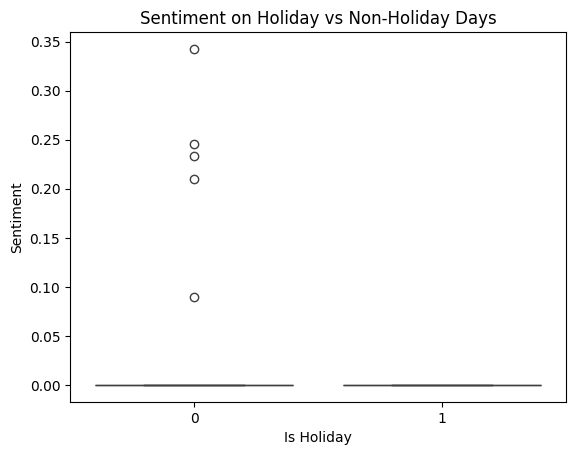

In [15]:
# plot the relationship between holidays and sentiment
sns.boxplot(x = 'is_holiday', y = 'sentiment', data = df_analysis)
plt.title("Sentiment on Holiday vs Non-Holiday Days")
plt.xlabel("Is Holiday")
plt.ylabel("Sentiment")
plt.show()

In [16]:
# regression on the relationship between the holiday and sentiment
# single-day holiday effect regression
model_simple = smf.ols('sentiment ~ is_holiday + google_trend', data = df_analysis).fit()
print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2481
Date:                Sat, 06 Dec 2025   Prob (F-statistic):              0.780
Time:                        22:32:04   Log-Likelihood:                 34676.
No. Observations:                9190   AIC:                        -6.935e+04
Df Residuals:                    9187   BIC:                        -6.933e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0001   7.27e-05      1.425   

In [17]:
# +/- three-day holiday window effect regression
model_window = smf.ols('sentiment ~ holiday_window + google_trend', data = df_analysis).fit()
print(model_window.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7467
Date:                Sat, 06 Dec 2025   Prob (F-statistic):              0.474
Time:                        22:32:04   Log-Likelihood:                 34677.
No. Observations:                9190   AIC:                        -6.935e+04
Df Residuals:                    9187   BIC:                        -6.933e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0001   7.84e-05      1.

**Question 2**: Is it possible to classify whether a day is “holiday season” or “normal season” using sentiment and engagement data?



In [18]:
# add rolling averages to capture trends around holidays
df['sentiment_roll3'] = df.groupby('brand')['sentiment'].transform(lambda x: x.rolling(3, min_periods = 1).mean())
df['buzz_roll3'] = df.groupby('brand')['buzz'].transform(lambda x: x.rolling(3, min_periods = 1).mean())
df['mentions_roll3'] = df.groupby('brand')['mentions'].transform(lambda x: x.rolling(3, min_periods = 1).mean())

# separate the other factors into X and focus on the holiday y
X = df[['sentiment_roll3', 'buzz_roll3', 'mentions_roll3', 'google_trend']]
y = df['is_holiday']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# perform a regression with class weighting
clf = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 42)

# fit the model
clf.fit(X_train_scaled, y_train)

# make predictions to compare
y_pred = clf.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division = 0))

Confusion Matrix:
[[ 561 1203]
 [  19   55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.32      0.48      1764
           1       0.04      0.74      0.08        74

    accuracy                           0.34      1838
   macro avg       0.51      0.53      0.28      1838
weighted avg       0.93      0.34      0.46      1838



**Question 3**: Which brands have similar engagement levels during holiday spikes?



In [19]:
# find only the days where it is a holiday
holiday_df = df[df['is_holiday'] == 1]

# filter by engagement
brand_engagement = holiday_df.groupby('brand')[['sentiment', 'buzz', 'mentions']].mean()

# standardize the values and fit it into the engagement
scaler = StandardScaler()
X_scaled = scaler.fit_transform(brand_engagement)

# do a nearest neighbors model and fit the training model
nn = NearestNeighbors(n_neighbors = 5)  # find five similar brands to compare
nn.fit(X_scaled)

# for each brand, find the five nearest brands to that one
distances, neighbors = nn.kneighbors(X_scaled)

# get a list of brand names
brand_list = brand_engagement.index.tolist()

# for each brand, find its info and print it out
for i, brand in enumerate(brand_list):
    similar_brands = [brand_list[j] for j in neighbors[i] if j != i]
    print(f"{brand} is similar to: {similar_brands}")

Amazon.com Inc. is similar to: ['Costco Wholesale Corp.', 'Apple Inc.', 'Walmart Inc.', 'Target Corp.']
Apple Inc. is similar to: ['Costco Wholesale Corp.', 'Amazon.com Inc.', 'Walmart Inc.', 'Target Corp.']
Costco Wholesale Corp. is similar to: ['Apple Inc.', 'Amazon.com Inc.', 'Walmart Inc.', 'Target Corp.']
Target Corp. is similar to: ['Costco Wholesale Corp.', 'Apple Inc.', 'Amazon.com Inc.', 'Walmart Inc.']
Walmart Inc. is similar to: ['Costco Wholesale Corp.', 'Apple Inc.', 'Amazon.com Inc.', 'Target Corp.']


**Question 4**: Can we group brands based on holiday sentiment and buzz patterns? Are some brands “holiday-sensitive” while others remain constant?


/tmp/ipython-input-19503725.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(brand_features['sentiment_change'][i], brand_features['buzz_change'][i], brand)


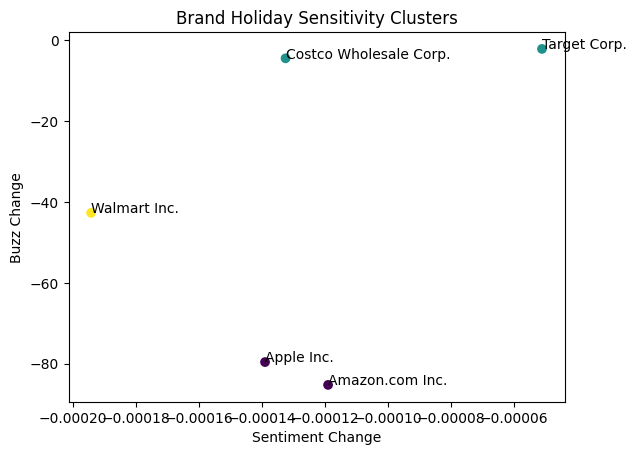

In [20]:
# calculates the average sentiment and buzz for each brand at the holiday
brand_features = df.groupby(['brand','is_holiday'])[['sentiment','buzz']].mean().unstack()

# find how much a brand's sentiment changes during the holiday
brand_features['sentiment_change'] = brand_features[('sentiment', 1)] - brand_features[('sentiment', 0)]

# find how much a brand's news buzz changes during the holiday
brand_features['buzz_change'] = brand_features[('buzz', 1)] - brand_features[('buzz', 0)]

# replace any missing values as 0
X = brand_features[['sentiment_change','buzz_change']].fillna(0)

# perform a KMeans clustering model, three clusers
kmeans = KMeans(n_clusters = 3, random_state = 42)
# fit the model
brand_features['cluster'] = kmeans.fit_predict(X)

# plot a cluster graph to show how brands group based on holiday responsiveness
plt.scatter(brand_features['sentiment_change'], brand_features['buzz_change'], c = brand_features['cluster'])
for i, brand in enumerate(brand_features.index):
    plt.text(brand_features['sentiment_change'][i], brand_features['buzz_change'][i], brand)
plt.xlabel('Sentiment Change')
plt.ylabel('Buzz Change')
plt.title('Brand Holiday Sensitivity Clusters')
plt.show()

**Question 5**: How do brand sentiment fluctuate 30 days before and after each holiday?

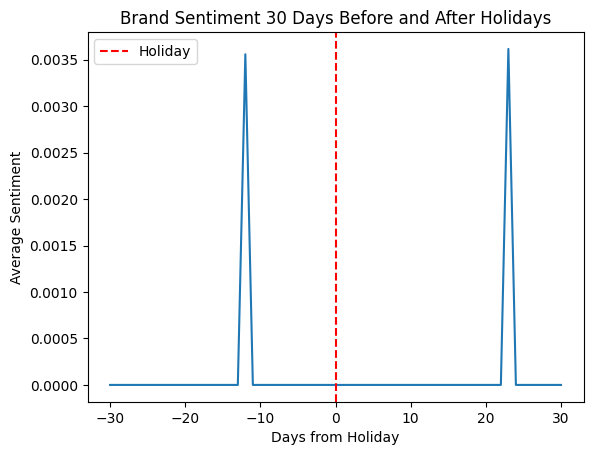

In [21]:
# create a 60 day winder for each holiday
window = 30  # days before and after

# filter only holiday days
holiday_days = df[df['is_holiday'] == 1]['date'].unique()

# create a new DataFrame with sentiment relative to holiday
holiday_sentiment_list = []

for h in holiday_days:
    temp = df[(df['date'] >= h - pd.Timedelta(days=window)) &
              (df['date'] <= h + pd.Timedelta(days=window))].copy()
    temp['days_from_holiday'] = (temp['date'] - h).dt.days
    holiday_sentiment_list.append(temp)

# combines all window DataFrames into one large DataFrame
holiday_sentiment_df = pd.concat(holiday_sentiment_list)

# calculates the average sentiment for each relative day across all holidays
sentiment_by_day = holiday_sentiment_df.groupby('days_from_holiday')['sentiment'].mean()

# plot the results
plt.plot(sentiment_by_day.index, sentiment_by_day.values)
plt.axvline(0, color='red', linestyle='--', label='Holiday')
plt.xlabel('Days from Holiday')
plt.ylabel('Average Sentiment')
plt.title('Brand Sentiment 30 Days Before and After Holidays')
plt.legend()
plt.show()

**Question 6**: Using NLP Neural Networks to detect holiday-related topics

In [22]:
# load a zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# example texts
texts = [
    "Cyber Monday deals are great!",
    "I went to the park today.",
    "Black Friday sales are amazing!",
    "Just cooking lunch for my family."
]

# candidate labels
labels = ["holiday", "non-holiday"]

# classify each text
for text in texts:
    result = classifier(text, candidate_labels=labels)
    print(f"'{text}' → {result['labels'][0]} (score: {result['scores'][0]:.2f})")

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


'Cyber Monday deals are great!' → holiday (score: 0.99)
'I went to the park today.' → non-holiday (score: 0.93)
'Black Friday sales are amazing!' → holiday (score: 0.99)
'Just cooking lunch for my family.' → non-holiday (score: 0.98)
